In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---
# 1- Emissions

In [2]:
def clean_emmissions_file(filename):
    """
    They all have just one zone
    """
    df = pd.read_csv(filename)
    
    df.rename(columns={'Datetime (UTC)':'DateUTC', 'Zone Id':'CountryCode'}, inplace=True)
    df['DateUTC'] = pd.to_datetime(df['DateUTC'])
    
    # When no value present, assume previous value
    df.fillna(method='ffill')
    
    return df[['DateUTC','Country','CountryCode','Carbon Intensity gCO₂eq/kWh (direct)','Carbon Intensity gCO₂eq/kWh (LCA)']]

In [3]:
es = clean_emmissions_file('./files/ES_2022_hourly.csv')
de = clean_emmissions_file('./files/DE_2022_hourly.csv')
fr = clean_emmissions_file('./files/FR_2022_hourly.csv')
pt = clean_emmissions_file('./files/PT_2022_hourly.csv')
fi = clean_emmissions_file('./files/FI_2022_hourly.csv')

emidf = pd.concat([es, de, fr, pt, fi]).reset_index(drop=True)

---
## 2-Load Values 

In [5]:
mon = pd.read_csv("./files/monthly_hourly_load_values_2022.csv", delimiter=";")
#mon['Value'] = mon['Value'].fillna(method='ffill')

In [6]:
mon.head()

,MeasureItem,DateUTC,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate
0,Monthly Hourly Load Values,01/01/2022 23:00,01/01/2022,23:00,00:00,AL,100,166.0,166.0,07/06/2023 15:31
1,Monthly Hourly Load Values,02/01/2022 00:00,02/01/2022,00:00,01:00,AL,100,144.0,144.0,07/06/2023 15:31
2,Monthly Hourly Load Values,02/01/2022 01:00,02/01/2022,01:00,02:00,AL,100,129.0,129.0,07/06/2023 15:31
3,Monthly Hourly Load Values,02/01/2022 02:00,02/01/2022,02:00,03:00,AL,100,123.0,123.0,07/06/2023 15:31
4,Monthly Hourly Load Values,02/01/2022 03:00,02/01/2022,03:00,04:00,AL,100,122.0,122.0,07/06/2023 15:31


In [7]:
mon['DateUTC'] = pd.to_datetime(mon['DateUTC'], format='%d/%m/%Y %H:%M')

In [8]:
# Adjust for GWh
mon['GWh'] = mon['Value']/1000

In [9]:
monr = mon[['DateUTC', 'CountryCode', 'GWh']]

In [10]:
monr

,DateUTC,CountryCode,GWh
0,2022-01-01 23:00:00,AL,0.16600
1,2022-01-02 00:00:00,AL,0.14400
2,2022-01-02 01:00:00,AL,0.12900
3,2022-01-02 02:00:00,AL,0.12300
4,2022-01-02 03:00:00,AL,0.12200
...,...,...,...
299305,2022-12-31 19:00:00,XK,1.05907
299306,2022-12-31 20:00:00,XK,0.96989
299307,2022-12-31 21:00:00,XK,0.94279
299308,2022-12-31 22:00:00,XK,0.83732


In [11]:
powemi = monr.merge(emidf, on=['DateUTC', 'CountryCode'], how='right')

---
# 3-Population

In [12]:
pop = pd.read_csv("./files/EU_population.txt")

In [13]:
full = powemi.merge(pop[['CountryCode','Population']], on='CountryCode', how='left')

In [14]:
full

,DateUTC,CountryCode,GWh,Country,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),Population
0,2022-01-01 00:00:00,ES,20.8270,Spain,112.92,153.49,48059777
1,2022-01-01 01:00:00,ES,19.5300,Spain,113.41,153.80,48059777
2,2022-01-01 02:00:00,ES,18.3830,Spain,117.61,158.94,48059777
3,2022-01-01 03:00:00,ES,17.6800,Spain,117.53,158.61,48059777
4,2022-01-01 04:00:00,ES,17.3960,Spain,115.89,156.98,48059777
...,...,...,...,...,...,...,...
43800,2022-12-31 19:00:00,FI,9.4084,Finland,66.34,98.74,5563970
43801,2022-12-31 20:00:00,FI,9.6646,Finland,68.33,101.29,5563970
43802,2022-12-31 21:00:00,FI,9.5826,Finland,68.57,101.44,5563970
43803,2022-12-31 22:00:00,FI,9.2415,Finland,70.49,104.14,5563970


---
# 4-Scatter Plots

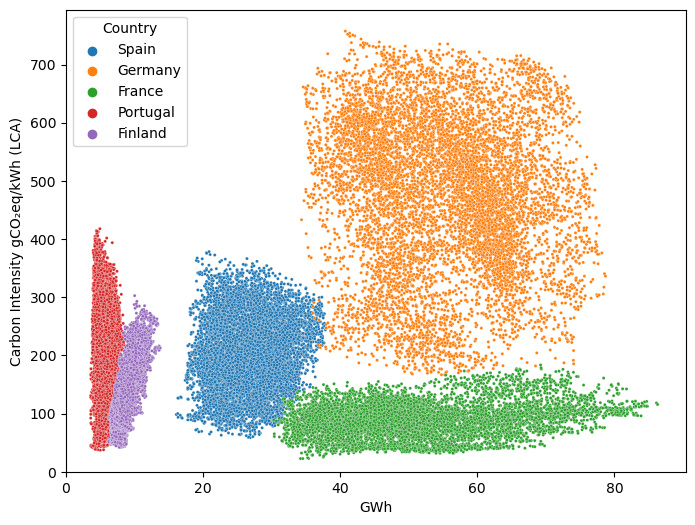

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x='GWh', y='Carbon Intensity gCO₂eq/kWh (LCA)', data=full, hue='Country', s=5, ax=ax)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.show()

In [16]:
full['Emissions per capita'] = full['GWh']*full['Carbon Intensity gCO₂eq/kWh (LCA)']/full['Population']*1e6
full['Consumption per capita'] = full['GWh']/full['Population']*1e6

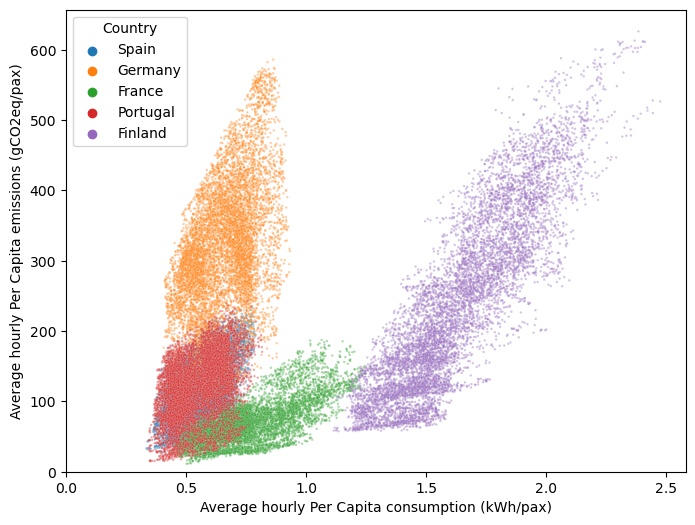

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x='Consumption per capita', y='Emissions per capita', data=full, hue='Country', s=3, ax=ax, alpha=0.4)

ax.set_xlabel("Average hourly Per Capita consumption (kWh/pax)")
ax.set_ylabel("Average hourly Per Capita emissions (gCO2eq/pax)")

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.show()

---
# 5-Time series

In [18]:
full['Grid emissions TCO₂eq'] = full['GWh']*full['Carbon Intensity gCO₂eq/kWh (direct)']

In [19]:
gem = full.pivot_table(index='DateUTC', columns=['Country'], values='Grid emissions TCO₂eq')

In [20]:
gem = gem[['Spain','Germany','France','Portugal','Finland']]

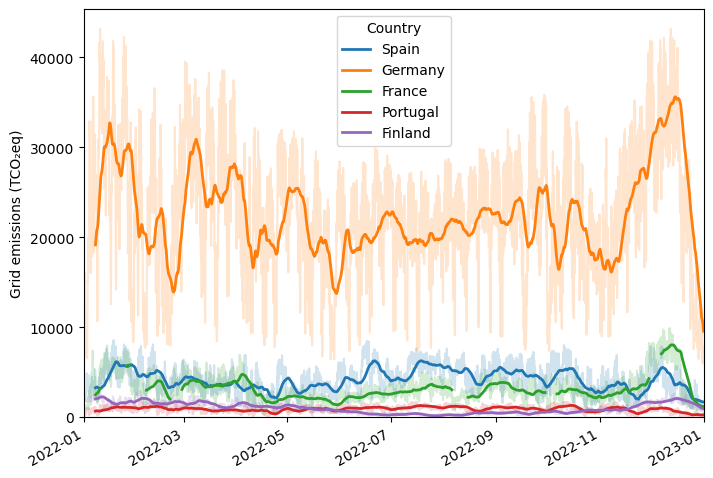

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

gem.plot(ax=ax, alpha=0.2, legend="")
gem.rolling(168).mean().plot(ax=ax, lw=2, color=['C0','C1','C2','C3','C4'])

#sns.lineplot(x='DateUTC', y='Grid emissions', data=full, hue='Country')

ax.set_ylabel("Grid emissions (TCO₂eq)")
ax.set_xlabel("")
ax.set_xlim('2022-01-01', '2023-01-01')
ax.set_ylim(bottom=0)
plt.show()

In [22]:
full['Grid emissions gCO₂eq/pax'] = full['GWh']*full['Carbon Intensity gCO₂eq/kWh (direct)']/full['Population']*1e6

gem2 = full.pivot_table(index='DateUTC', columns=['Country'], values='Grid emissions gCO₂eq/pax')
gem2 = gem2[['Spain','Germany','France','Portugal','Finland']]

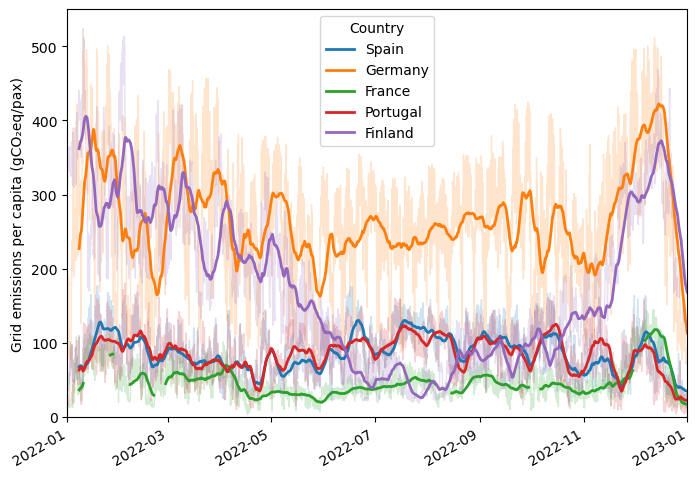

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

gem2.plot(ax=ax, lw=1, alpha=0.2, legend="")
gem2.rolling(168).mean().plot(ax=ax, lw=2, color=['C0','C1','C2','C3','C4'])


ax.set_ylabel("Grid emissions per capita (gCO₂eq/pax)")
ax.set_xlabel("")
ax.set_xlim('2022-01-01', '2023-01-01')
ax.set_ylim(bottom=0)
plt.show()